In [4]:
import os
import math
import pandas as pd
from scipy.stats import poisson

# --- Configuration ---
FOLDER_PATH = '/Users/user/XG/Eredivisie 2025-2026/xgCSV' 
OUTPUT_PATH = '/Users/user/Python/Eredivisie_xG_Summary.xlsx'
# --- End Configuration ---

# Team abbreviations
#TEAM_ABBR = {
 #   "Arsenal WFC": "ARS",
  #  "Aston Villa WFC": "AVL",
   # "Brighton & Hove Albion WFC": "BHA",
    #"Chelsea FC Women": "CHE",
    #"Everton FC": "EVE",
    #"Leicester City FC": "LEI",
    #"Liverpool FCW": "LIV",
    #"London City Lionesses LFC": "LCL",
    #"Manchester City WFC": "MCI",
    #"Manchester United WFC": "MUN",
    #"Tottenham Hotspur FCW": "TOT",
    #"West Ham United WFC": "WHU"
#}
# Team abbreviations - Eredivisie 2025/26
TEAM_ABBR = {
    "AFC Ajax": "AJA",
    "Alkmaar Zaanstreek": "AZ",
    "FC Groningen": "GRO",
    "FC Twente": "TWE",
    "FC Utrecht": "UTR",
    "FC Volendam": "VOL",
    "Feyenoord Rotterdam": "FEY",
    "Fortuna Sittard": "FOR",
    "Go Ahead Eagles": "GAE",
    "Heracles Almelo": "HER",
    "NAC Breda": "NAC",
    "Nijmegen Eendracht Combinatie": "NEC",
    "PEC Zwolle": "PEC",
    "PSV Eindhoven": "PSV",
    "SBV Excelsior": "EXC",
    "SC Heerenveen": "HEE",
    "SC Telstar": "TEL",
    "Sparta Rotterdam": "SPA"
}


def calculate_expected_points(xg_for, xg_against, max_goals=10):
    """Calculate expected points (xPts) using Poisson scoring probabilities."""
    win_prob, draw_prob, loss_prob = 0.0, 0.0, 0.0
    for goals_for in range(max_goals + 1):
        for goals_against in range(max_goals + 1):
            prob = poisson.pmf(goals_for, xg_for) * poisson.pmf(goals_against, xg_against)
            if goals_for > goals_against:
                win_prob += prob
            elif goals_for == goals_against:
                draw_prob += prob
            else:
                loss_prob += prob
    return 3 * win_prob + 1 * draw_prob


def analyze_and_print_details(df, filename):
    """Print a detailed match analysis."""
    print(f"\n--- Detailed Analysis for: {filename} ---")
    
    if df.empty or 'TeamId' not in df.columns or 'xG' not in df.columns:
        print("Data empty or missing columns. Skipping.")
        print("-------------------------------------------------")
        return

    teams = df['TeamId'].unique()
    if len(teams) < 2:
        print(f"Only one team found: {teams[0]}. Skipping.")
        print("-------------------------------------------------")
        return
        
    team1, team2 = teams[0], teams[1]

    # Team 1
    shots1 = df[df['TeamId'] == team1].shape[0]
    xg1 = df[df['TeamId'] == team1]['xG'].sum()
    goals1 = df[(df['TeamId'] == team1) & (df.get('isGoal', False) == True)].shape[0]
    xg_per_shot1 = xg1 / shots1 if shots1 > 0 else 0

    # Team 2
    shots2 = df[df['TeamId'] == team2].shape[0]
    xg2 = df[df['TeamId'] == team2]['xG'].sum()
    goals2 = df[(df['TeamId'] == team2) & (df.get('isGoal', False) == True)].shape[0]
    xg_per_shot2 = xg2 / shots2 if shots2 > 0 else 0

    # Metrics
    xga1, xgd1 = xg2, xg1 - xg2
    gd1 = goals1 - goals2
    xga2, xgd2 = xg1, xg2 - xg1
    gd2 = goals2 - goals1

    xpts1 = calculate_expected_points(xg1, xg2)
    xpts2 = calculate_expected_points(xg2, xg1)
    pts1, pts2 = (3,0) if goals1>goals2 else (0,3) if goals1<goals2 else (1,1)

    print("\n## Team Performance (Per Game)")
    print(f"| {'Team':<20} | {'xG':<5} | {'xGA':<5} | {'xGD':<6} | {'Goals':<6} | {'GC':<5} | {'GD':<5} | {'xG/Shot':<10} | {'xPts':<6} | {'Pts':<5} |")
    print(f"|:{'-'*20}|:{'-'*5}|:{'-'*5}|:{'-'*6}|:{'-'*6}|:{'-'*5}|:{'-'*5}|:{'-'*10}|:{'-'*6}|:{'-'*5}|")
    print(f"| {team1:<20} | {xg1:<5.2f} | {xga1:<5.2f} | {xgd1:<6.2f} | {goals1:<6} | {goals2:<5} | {gd1:<5} | {xg_per_shot1:<10.3f} | {xpts1:<6.2f} | {pts1:<5} |")
    print(f"| {team2:<20} | {xg2:<5.2f} | {xga2:<5.2f} | {xgd2:<6.2f} | {goals2:<6} | {goals1:<5} | {gd2:<5} | {xg_per_shot2:<10.3f} | {xpts2:<6.2f} | {pts2:<5} |")

    print("\n## Key Events")
    if 'isGoal' in df.columns and 'timeMin' in df.columns and 'PlayerId' in df.columns:
        goals = df[df['isGoal'] == True]
        if not goals.empty:
            print("\n* Goals Scored:")
            for _, goal in goals.iterrows():
                print(f"  - Minute {goal['timeMin']}: Goal by {goal['PlayerId']} ({goal['TeamId']}). (xG: {goal['xG']:.3f})")
        else:
            print("\n* Goals Scored: None")
    else:
        print("\n* Goal data not available.")

    if not df.empty and 'xG' in df.columns:
        biggest_chance = df.loc[df['xG'].idxmax()]
        print(f"\n* Biggest Chance:")
        print(f"  - A shot by {biggest_chance.get('PlayerId', 'N/A')} ({biggest_chance.get('TeamId', 'N/A')}) in minute {biggest_chance.get('timeMin', 'N/A')} had the highest xG of the match: {biggest_chance['xG']:.3f}.")
    else:
        print("\n* Biggest Chance: Data not available.")

    print("-------------------------------------------------")


def main():
    if not os.path.isdir(FOLDER_PATH):
        print(f"Error: Directory not found at '{FOLDER_PATH}'.")
        return

    print(f"📁 Loading game data from: {FOLDER_PATH}")
    team_totals = {}

    for filename in os.listdir(FOLDER_PATH):
        if filename.endswith('.csv'):
            file_path = os.path.join(FOLDER_PATH, filename)
            try:
                game_df = pd.read_csv(file_path)
                analyze_and_print_details(game_df, filename)

                if 'TeamId' in game_df.columns and 'xG' in game_df.columns:
                    teams = game_df['TeamId'].unique()
                    if len(teams) >= 2:
                        team1, team2 = teams[0], teams[1]

                        shots1 = game_df[game_df['TeamId'] == team1].shape[0]
                        xg1 = game_df[game_df['TeamId'] == team1]['xG'].sum()
                        goals1 = game_df[(game_df['TeamId'] == team1) & (game_df.get('isGoal', False) == True)].shape[0]

                        shots2 = game_df[game_df['TeamId'] == team2].shape[0]
                        xg2 = game_df[game_df['TeamId'] == team2]['xG'].sum()
                        goals2 = game_df[(game_df['TeamId'] == team2) & (game_df.get('isGoal', False) == True)].shape[0]

                        xpts1 = calculate_expected_points(xg1, xg2)
                        xpts2 = calculate_expected_points(xg2, xg1)
                        pts1, pts2 = (3,0) if goals1>goals2 else (0,3) if goals1<goals2 else (1,1)

                        # Update totals
                        for team, shots, xg, xga, goals, gc, xpts, pts in [
                            (team1, shots1, xg1, xg2, goals1, goals2, xpts1, pts1),
                            (team2, shots2, xg2, xg1, goals2, goals1, xpts2, pts2)
                        ]:
                            if team not in team_totals:
                                team_totals[team] = {'xG':0,'xGA':0,'Goals':0,'Goals Conceded':0,
                                                     'Total Shots':0,'xPts':0,'Pts':0,'Games':0}
                            team_totals[team]['xG'] += xg
                            team_totals[team]['xGA'] += xga
                            team_totals[team]['Goals'] += goals
                            team_totals[team]['Goals Conceded'] += gc
                            team_totals[team]['Total Shots'] += shots
                            team_totals[team]['xPts'] += xpts
                            team_totals[team]['Pts'] += pts
                            team_totals[team]['Games'] += 1

            except Exception as e:
                print(f"\n--- Error processing file: {filename} ---")
                print(f"An error occurred: {e}")
                print("-------------------------------------------------")

    if team_totals:
        print("\n" + "="*50)
        print("## Cumulative League Totals (All Games Processed)")
        
        df_totals = pd.DataFrame.from_dict(team_totals, orient='index')
        df_totals = df_totals.sort_index()

        df_totals['xGD'] = df_totals['xG'] - df_totals['xGA']
        df_totals['GD'] = df_totals['Goals'] - df_totals['Goals Conceded']
        df_totals['xG per Shot'] = df_totals['xG'] / df_totals['Total Shots']
        df_totals.loc[df_totals['Total Shots'] == 0, 'xG per Shot'] = 0

        # Per-game stats
        df_totals['xPts/Game'] = df_totals['xPts'] / df_totals['Games']
        df_totals['Pts/Game'] = df_totals['Pts'] / df_totals['Games']

        # Add abbreviations
        df_totals['Abbr'] = df_totals.index.map(TEAM_ABBR)
        cols = ['Abbr'] + [c for c in df_totals.columns if c != 'Abbr']
        df_totals = df_totals[cols]

        print(df_totals.to_markdown())

        try:
            df_totals.to_excel(OUTPUT_PATH, engine='openpyxl')
            print(f"\n✅ Successfully saved cumulative data to '{OUTPUT_PATH}'")
        except Exception as e:
            print(f"\n❌ Error saving to Excel: {e}")
            print("Please ensure 'openpyxl' is installed (`pip install openpyxl`).")

    else:
        print("\nNo complete game data found to calculate cumulative totals.")


if __name__ == '__main__':
    main()


📁 Loading game data from: /Users/user/XG/Eredivisie 2025-2026/xgCSV

--- Detailed Analysis for: 2025-08-30_PSV Eindhoven - SC Telstar.csv ---

## Team Performance (Per Game)
| Team                 | xG    | xGA   | xGD    | Goals  | GC    | GD    | xG/Shot    | xPts   | Pts   |
|:--------------------|:-----|:-----|:------|:------|:-----|:-----|:----------|:------|:-----|
| SC Telstar           | 1.29  | 2.55  | -1.26  | 2      | 0     | 2     | 0.144      | 0.71   | 3     |
| PSV Eindhoven        | 2.55  | 1.29  | 1.26   | 0      | 2     | -2    | 0.111      | 2.12   | 0     |

## Key Events

* Goals Scored:
  - Minute 20: Goal by T. Owusu (SC Telstar). (xG: 0.033)
  - Minute 64: Goal by P. Brouwer (SC Telstar). (xG: 0.534)

* Biggest Chance:
  - A shot by P. Brouwer (SC Telstar) in minute 64 had the highest xG of the match: 0.534.
-------------------------------------------------

--- Detailed Analysis for: 2025-08-31_Sparta Rotterdam - Feyenoord Rotterdam.csv ---

## Team Performance

✅ Plot saved as PNG: /Users/user/Python/Eredivisie_xG_Scatter.png


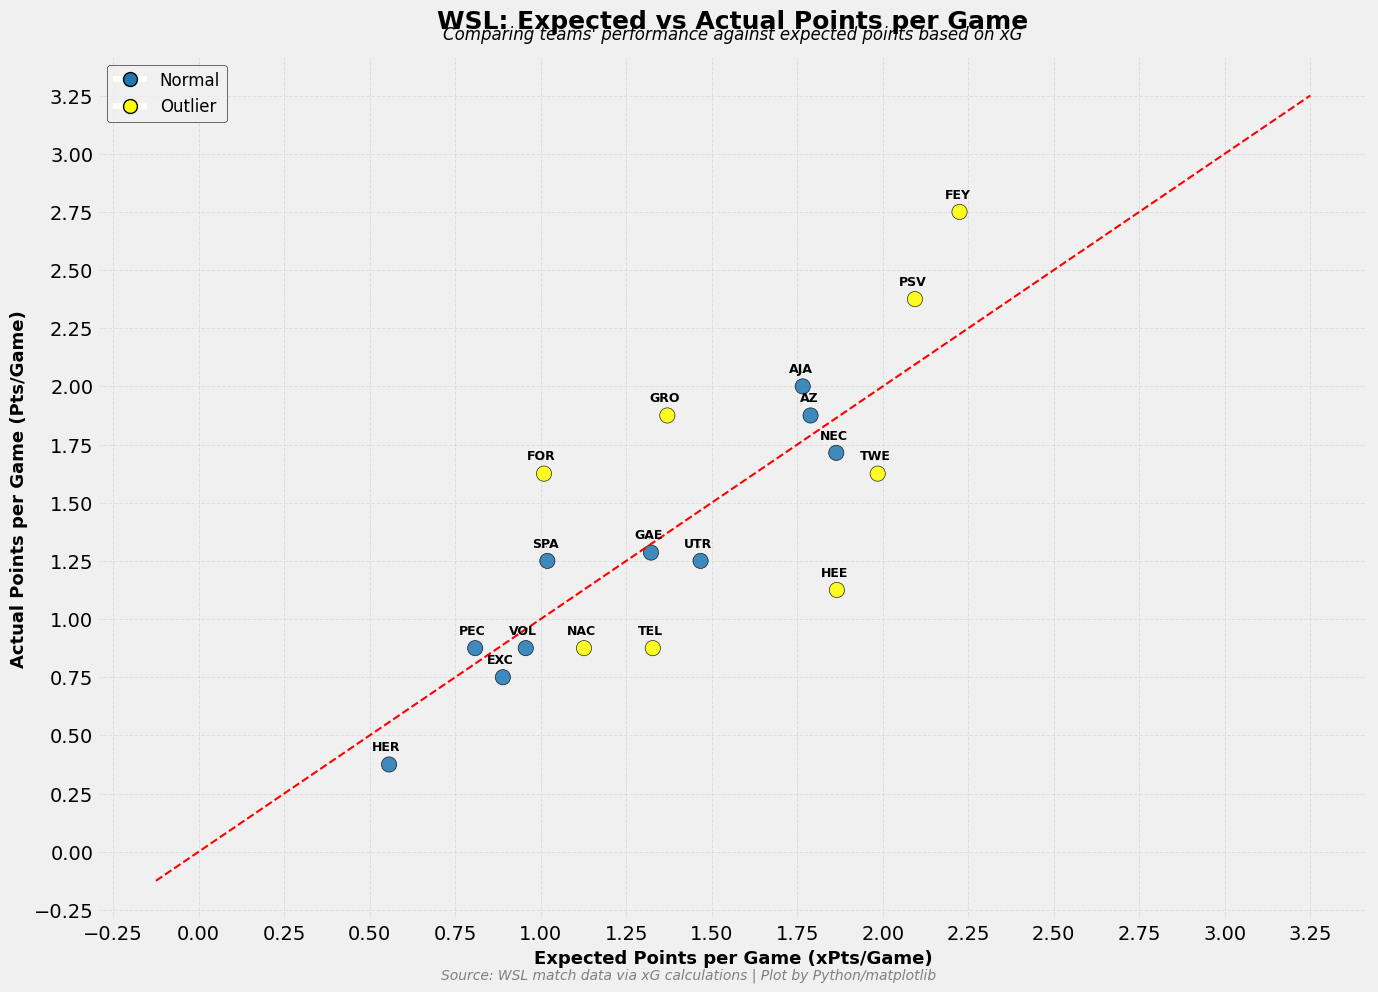

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np
from matplotlib.lines import Line2D

# --- Load Data ---
file_path = '/Users/user/Python/Eredivisie_xG_Summary.xlsx'
df_totals = pd.read_excel(file_path, index_col=0)

# --- Calculate Differences for Outliers ---
df_totals['Diff'] = df_totals['Pts/Game'] - df_totals['xPts/Game']
threshold = 0.25
colors = np.where(abs(df_totals['Diff']) > threshold, 'yellow', '#1f77b4')

# --- Scatter Plot ---
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter points
scatter = ax.scatter(df_totals['xPts/Game'], df_totals['Pts/Game'],
                     color=colors, s=120, alpha=0.85, edgecolors='k', linewidth=0.5)

# Vertical offset for labels
y_range = df_totals['Pts/Game'].max() - df_totals['Pts/Game'].min()
offset = y_range * 0.02

# Add team abbreviation labels
texts = []
for team, row in df_totals.iterrows():
    label = row['Abbr'] if 'Abbr' in df_totals.columns else team
    texts.append(
        ax.text(row['xPts/Game'], row['Pts/Game'] + offset, label,
                fontsize=9, weight='bold', ha='center')
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.7), ax=ax)

# 45° reference line
min_val = min(df_totals['xPts/Game'].min(), df_totals['Pts/Game'].min()) - 0.5
max_val = max(df_totals['xPts/Game'].max(), df_totals['Pts/Game'].max()) + 0.5
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5,
        label='xPts/Game = Pts/Game')

# Optional shading
ax.fill_between([min_val, max_val], [min_val, max_val], [min_val, max_val], color='green', alpha=0.05)

# Set axis ticks
ax.set_xticks(np.arange(np.floor(min_val*4)/4, np.ceil(max_val*4)/4 + 0.25, 0.25))
ax.set_yticks(np.arange(np.floor(min_val*4)/4, np.ceil(max_val*4)/4 + 0.25, 0.25))

# Titles and subtitles
ax.set_title("WSL: Expected vs Actual Points per Game", fontsize=18, weight='bold', pad=20)
ax.text(0.5, 1.02, "Comparing teams' performance against expected points based on xG",
        transform=ax.transAxes, ha='center', fontsize=12, style='italic')

# Axis labels
ax.set_xlabel("Expected Points per Game (xPts/Game)", fontsize=13, weight='bold')
ax.set_ylabel("Actual Points per Game (Pts/Game)", fontsize=13, weight='bold')

# Grid and style
ax.grid(True, linestyle='--', alpha=0.5, linewidth=0.7)
ax.set_axisbelow(True)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='#1f77b4', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Outlier', markerfacecolor='yellow', markersize=10, markeredgecolor='k')
]
ax.legend(handles=legend_elements, fontsize=12, loc='upper left', frameon=True, edgecolor='k')

# Data source / footnote
fig.text(0.5, 0.01, 'Source: WSL match data via xG calculations | Plot by Python/matplotlib',
         ha='center', fontsize=10, color='gray', style='italic')

# Tight layout
plt.tight_layout()

# --- Save to PNG ---
output_png = '/Users/user/Python/Eredivisie_xG_Scatter.png'
fig.savefig(output_png, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved as PNG: {output_png}")

plt.show()
